# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'
Plugins(categories=["generic"]).list()


[2023-11-23T03:31:25.287140+0000][1530][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2023-11-23T03:31:25.288837+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:25.290983+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:31:25.299446+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


['marginal_distributions',
 'dummy_sampler',
 'arf',
 'bayesian_network',
 'nflow',
 'uniform_sampler',
 'tvae',
 'ddpm',
 'ctgan',
 'rtvae']

# Load data and settings

In [2]:
from DGE_data import get_real_and_synthetic

print("cuda available? " + str(torch.cuda.is_available()))
print("torch device: " + str(device))
# let's restrict ourselves to classification datasets
# datasets = ['moons', 'circles', 'breast_cancer',
#            'adult',  'seer', 'covid']
datasets = ['moons', 'circles', 'breast_cancer',
            'adult', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'tvae'  # synthetic data model

n_models = 5  # number of models in ensemble, for each run orig: 20
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5 # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models, orig:10

# Whether to load and save models and synthetic datasets
load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = True

cuda available? True
torch device: cuda


# Experiments

## Model Training

Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss  hours.per.week  native.country  income  
0          2174             0              40  

[2023-11-23T03:31:38.615890+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:38.617158+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:38.618396+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:31:38.620410+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


original income column: 
 0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
48837    <=50K.
48838    <=50K.
48839    <=50K.
48840    <=50K.
48841     >50K.
Name: income, Length: 48842, dtype: object
after mapping: 
 0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64
input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  21

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/tmp/tmps5untnx8
INFO:torch.distributed.nn.jit.instantiator:Writing /var/tmp/tmps5untnx8/_remote_module_non_scriptable.py
 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:23<02:23,  3.48it/s]
[2023-11-23T03:34:13.032896+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:34:13.034189+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:34:13.036753+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:34:13.038796+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed1.pkl
Training model 2/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T03:36:38.831431+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:36:38.832665+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:36:38.833618+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:36:38.836092+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed2.pkl
Training model 3/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:19<02:19,  3.59it/s]
[2023-11-23T03:39:06.253495+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:39:06.254851+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:39:06.256493+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:39:06.259179+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed3.pkl
Training model 4/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T03:41:31.814762+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:41:31.816708+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:41:31.818918+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:41:31.821116+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed4.pkl
Training model 5/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:16<02:16,  3.66it/s]
[2023-11-23T03:43:56.410809+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:43:56.414193+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:43:56.415121+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:43:56.417738+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed5.pkl
Training model 6/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:16<02:16,  3.66it/s]
[2023-11-23T03:46:21.203976+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:46:21.205162+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:46:21.207722+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:46:21.210944+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed6.pkl
Training model 7/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.73it/s]
[2023-11-23T03:48:42.883136+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:48:42.886550+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:48:42.887602+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:48:42.890083+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed7.pkl
Training model 8/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.70it/s]
[2023-11-23T03:51:06.459203+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:51:06.460471+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:51:06.462761+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:51:06.464193+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed8.pkl
Training model 9/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T03:53:27.560558+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:53:27.561873+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:53:27.564473+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:53:27.566126+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed9.pkl
Training model 10/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T03:55:48.924804+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:55:48.926039+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:55:48.927729+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:55:48.930509+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed10.pkl
Training model 11/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.71it/s]
[2023-11-23T03:58:11.567887+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:58:11.569081+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:58:11.571512+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:58:11.572905+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed11.pkl
Training model 12/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T04:00:37.174264+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:00:37.175462+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:00:37.176267+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:00:37.178936+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed12.pkl
Training model 13/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.76it/s]
[2023-11-23T04:02:57.948433+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:02:57.949689+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:02:57.950526+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:02:57.953231+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed13.pkl
Training model 14/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.73it/s]
[2023-11-23T04:05:20.337217+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:05:20.338551+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:05:20.341140+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:05:20.342893+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed14.pkl
Training model 15/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.73it/s]
[2023-11-23T04:07:42.059199+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:07:42.060408+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:07:42.061196+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:07:42.063748+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed15.pkl
Training model 16/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.71it/s]
[2023-11-23T04:10:04.948485+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:10:04.949782+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:10:04.950665+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:10:04.958351+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed16.pkl
Training model 17/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T04:12:26.059672+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:12:26.060939+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:12:26.063569+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:12:26.065365+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed17.pkl
Training model 18/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:12<02:12,  3.77it/s]
[2023-11-23T04:14:46.422875+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:14:46.424252+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:14:46.426926+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:14:46.428668+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed18.pkl
Training model 19/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.69it/s]
[2023-11-23T04:17:09.862842+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:17:09.864678+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:17:09.866772+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:17:09.869138+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed19.pkl
Training model 20/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T04:19:31.263947+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:19:31.265068+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:19:31.267423+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:19:31.268891+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed20.pkl
Training model 21/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T04:21:52.209047+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:21:52.210215+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:21:52.211323+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:21:52.213905+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed21.pkl
Training model 22/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.68it/s]
[2023-11-23T04:24:15.786790+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:24:15.788001+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:24:15.789010+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:24:15.793201+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed22.pkl
Training model 23/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T04:26:37.016669+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:26:37.017900+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:26:37.020364+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:26:37.022486+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed23.pkl
Training model 24/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:12<02:12,  3.76it/s]
[2023-11-23T04:28:57.598220+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:28:57.599451+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:28:57.601995+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:28:57.603854+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed24.pkl
Training model 25/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]


Finished with synthetic data generation!
Dataset adult

targettype:  classification
\begin{tabular}{lrrrrrrr}
\toprule
{} &       AUC &       Acc &        F1 &  Precision &    Recall &       NLL &     Brier \\
\midrule
Oracle              &  0.857023 &  0.809914 &  0.592830 &   0.608068 &  0.578337 &  0.506772 &  0.139093 \\
Naive (S)           &  0.745755 &  0.787029 &  0.433954 &   0.596010 &  0.341185 &  0.905341 &  0.175967 \\
Naive (E)           &  0.784025 &  0.794052 &  0.462113 &   0.616025 &  0.369736 &  0.547085 &  0.154151 \\
DGE\$\_\{5\}\$           &  0.776065 &  0.790637 &  0.464537 &   0.598565 &  0.379550 &  0.607757 &  0.157876 \\
DGE\$\_\{10\}\$          &  0.781384 &  0.792964 &  0.466322 &   0.608415 &  0.378034 &  0.572122 &  0.155128 \\
DGE\$\_\{20\}\$          &  0.784030 &  0.792750 &  0.464711 &   0.608256 &  0.375981 &  0.550062 &  0.154297 \\
DGE\$\_\{20\}\$ (concat) &  0.736815 &  0.752829 &  0.452214 &   0.481366 &  0.426392 &  3.247981 &  0.232554 \\
\bott

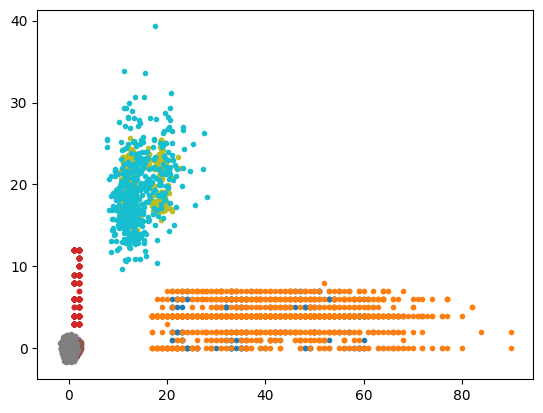

In [3]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}

#datasets = ['moons', 'circles', 'breast_cancer', 'adult', 'covid', 'seer']
datasets = ['adult', 'covid', 'moons', 'circles', 'breast_cancer']
#num_runs=10
model_type = 'deepish_mlp'

for dataset in datasets:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)


    print(f'Dataset {dataset}\n')

    means, stds, _ = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            task_type = model_type
                                            )

    print(means.to_latex())

    all_means[dataset] = means
    all_stds[dataset] = stds



In [4]:
# Print results, aggregated over different datasets
means_consolidated = metric_different_datasets(all_means, to_print=False)
if num_runs>1:
    stds_consolidated = metric_different_datasets(all_stds, to_print=False)
    stds_consolidated.drop(columns=['Mean'], inplace=True)
    print(add_std(means_consolidated, stds_consolidated).to_latex())
else:
    print(means_consolidated.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &        Moons &      Circles & Adult Income & Breast Cancer &     COVID-19 &   Mean \\
\midrule
Oracle              &  0.996 ± 0.0 &  0.868 ± 0.0 &  0.857 ± 0.0 &   0.993 ± 0.0 &  0.929 ± 0.0 &  0.929 \\
Naive (S)           &  0.989 ± 0.0 &   0.86 ± 0.0 &  0.746 ± 0.0 &   0.959 ± 0.0 &  0.787 ± 0.0 &  0.868 \\
Naive (E)           &  0.988 ± 0.0 &  0.861 ± 0.0 &  0.784 ± 0.0 &   0.968 ± 0.0 &  0.837 ± 0.0 &  0.887 \\
DGE\$\_\{5\}\$           &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.776 ± 0.0 &    0.97 ± 0.0 &  0.818 ± 0.0 &  0.882 \\
DGE\$\_\{10\}\$          &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.781 ± 0.0 &   0.965 ± 0.0 &  0.833 ± 0.0 &  0.886 \\
DGE\$\_\{20\}\$          &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.784 ± 0.0 &   0.963 ± 0.0 &  0.835 ± 0.0 &  0.886 \\
DGE\$\_\{20\}\$ (concat) &   0.92 ± 0.0 &  0.691 ± 0.0 &  0.737 ± 0.0 &   0.932 ± 0.0 &  0.763 ± 0.0 &  0.809 \\
\bottomrule
\end{tabular}



### Run over generative model sizes
Let us study what happens when we run the generative model for different sizes.

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd
genrun_all = {}
#dataset = 'seer'
dataset = 'adult'

max_n = 5000
nsyn = 5000
model_type = 'deepish_mlp'
num_runs = 10

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)

    print(f'Model {model_name}\n')

    means, stds, all = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            task_type=model_type,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            )

    all['Hidden layers'] = layers
    genrun_all[layers] = all



Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss  hours.per.week  native.country  income  
0          2174             0              40  

[2023-11-23T05:18:34.923413+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:18:34.924771+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:18:34.926956+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:18:34.928460+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  215419             13               0          10   
48838   64          0  321403              9               6           0   
48839   38          4  374983             13               2          10   
48840   44          4   83891             13               0           1   
48841   35          5  182148             13               2           4   

       relationship  race  sex  capital.gain  capital.loss  hours.per

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1199/2000 [16:07<10:46,  1.24it/s]
[2023-11-23T05:34:55.588728+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:34:55.589988+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:34:55.591512+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:34:55.593605+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed1.pkl
Training model 2/50


 20%|█████████████████████████████████                                                                                                                                     | 399/2000 [05:12<20:55,  1.28it/s]
[2023-11-23T05:40:22.331707+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:40:22.332907+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:40:22.335366+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:40:22.337140+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed2.pkl
Training model 3/50


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 649/2000 [08:22<17:25,  1.29it/s]
[2023-11-23T05:48:57.870658+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:48:57.871880+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:48:57.874341+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:48:57.876273+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed3.pkl
Training model 4/50


 25%|█████████████████████████████████████████▍                                                                                                                            | 499/2000 [06:18<18:59,  1.32it/s]
[2023-11-23T05:55:30.671781+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:55:30.672872+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:55:30.673939+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:55:30.677187+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed4.pkl
Training model 5/50


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1449/2000 [18:49<07:09,  1.28it/s]
[2023-11-23T06:14:33.178383+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:14:33.179632+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:14:33.182152+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:14:33.183983+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed5.pkl
Training model 6/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [12:45<12:47,  1.30it/s]
[2023-11-23T06:27:32.168922+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:27:32.170172+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:27:32.172830+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:27:32.174727+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed6.pkl
Training model 7/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [08:36<16:00,  1.35it/s]
[2023-11-23T06:36:21.683236+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:36:21.684292+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:36:21.686924+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:36:21.688793+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed7.pkl
Training model 8/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [07:11<16:49,  1.39it/s]
[2023-11-23T06:43:46.690751+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:43:46.692013+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:43:46.694460+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:43:46.696200+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed8.pkl
Training model 9/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [08:24<15:38,  1.39it/s]
[2023-11-23T06:52:24.383206+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:52:24.384367+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:52:24.386991+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:52:24.388710+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed9.pkl
Training model 10/50


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 899/2000 [10:54<13:21,  1.37it/s]
[2023-11-23T07:03:31.778679+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:03:31.779834+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:03:31.782196+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:03:31.784667+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed10.pkl
Training model 11/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:49<14:44,  1.42it/s]
[2023-11-23T07:12:34.241358+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:12:34.242469+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:12:34.244936+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:12:34.246670+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed11.pkl
Training model 12/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:42<14:32,  1.43it/s]
[2023-11-23T07:21:30.082214+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:21:30.083311+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:21:30.085802+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:21:30.088812+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed12.pkl
Training model 13/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:37<14:24,  1.45it/s]
[2023-11-23T07:30:21.590708+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:30:21.591755+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:30:21.593956+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:30:21.596051+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed13.pkl
Training model 14/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:30<14:12,  1.47it/s]
[2023-11-23T07:39:05.320256+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:39:05.324382+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:39:05.328198+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:39:05.332153+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed14.pkl
Training model 15/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:36<11:37,  1.44it/s]
[2023-11-23T07:50:54.996860+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:50:54.997942+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:50:55.000442+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:50:55.002117+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed15.pkl
Training model 16/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:34<11:35,  1.44it/s]
[2023-11-23T08:02:42.823800+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:02:42.824959+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:02:42.826559+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:02:42.829909+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed16.pkl
Training model 17/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:34<11:35,  1.44it/s]
[2023-11-23T08:14:30.325768+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:14:30.327027+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:14:30.329429+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:14:30.331664+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed17.pkl
Training model 18/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:23<09:54,  1.43it/s]
[2023-11-23T08:28:06.874483+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:28:06.875698+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:28:06.878342+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:28:06.880203+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed18.pkl
Training model 19/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:13<09:47,  1.45it/s]
[2023-11-23T08:41:34.147529+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:41:34.148649+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:41:34.150962+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:41:34.152856+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed19.pkl
Training model 20/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:07<09:43,  1.46it/s]
[2023-11-23T08:54:54.755985+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:54:54.757228+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:54:54.759743+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:54:54.761593+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed20.pkl
Training model 21/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:00<09:37,  1.47it/s]
[2023-11-23T09:08:08.521673+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:08:08.522824+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:08:08.525130+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:08:08.526976+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed21.pkl
Training model 22/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:53<09:33,  1.48it/s]
[2023-11-23T09:21:15.685025+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:21:15.686220+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:21:15.688635+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:21:15.690499+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed22.pkl
Training model 23/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:45<09:27,  1.50it/s]
[2023-11-23T09:34:14.820855+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:34:14.821869+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:34:14.824288+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:34:14.827363+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed23.pkl
Training model 24/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T09:47:08.668843+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:47:08.670007+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:47:08.672224+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:47:08.673922+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed24.pkl
Training model 25/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.51it/s]
[2023-11-23T10:00:00.401816+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:00:00.402970+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:00:00.405202+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:00:00.407119+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed25.pkl
Training model 26/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:22,  1.51it/s]
[2023-11-23T10:12:52.666370+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:12:52.667560+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:12:52.669979+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:12:52.671833+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed26.pkl
Training model 27/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:36<09:20,  1.52it/s]
[2023-11-23T10:25:42.340601+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:25:42.341760+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:25:42.344077+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:25:42.345959+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed27.pkl
Training model 28/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:39<09:22,  1.51it/s]
[2023-11-23T10:38:34.612633+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:38:34.613842+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:38:34.616215+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:38:34.618036+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed28.pkl
Training model 29/50


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1077/2000 [11:49<09:42,  1.58it/s]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfs = pd.concat(genrun_all)
oracle = dfs[dfs['Approach']=='Oracle']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=='Naive (E)')]

metric = 'Acc'

sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect = 2, height=3, showfliers = False, legend=False)
plt.tight_layout()
#draw line for oracle mean
plt.axhline(oracle[metric].mean(), color='black', linestyle='--', label='$\mathcal{D}_R$-model')
plt.legend()
os.makedirs('results/stories', exist_ok=True)
plt.savefig(f'results/stories/training_models_{dataset}_max_n{max_n}_nsyn_{nsyn}_{model_type}_{metric}.png', dpi=300)
plt.show()

## Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Naive evaluation]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle evaluation]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [DGE evaluation]
6. Average over all models $f_i$. 

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [ ]:
from DGE_experiments import model_evaluation_experiment

evaluation_means = {}
evaluation_std = {}
relative = False
max_n = 5000
nsyn = 5000
model_name = 'ctgan_deep'
#datasets = ['moons', 'circles', 'adult', 'seer', 'covid']
datasets = ['moons', 'circles', 'adult', 'covid']
model_type = 'deepish_mlp'
verbose = True

for dataset in datasets:
    print('Dataset:', dataset)
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)


    

    # load data
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    # get mean and std of dataset over different runs
    means, std, _ = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type=model_type,
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             )

    evaluation_means[dataset] = means
    evaluation_std[dataset] = std


In [ ]:
# mean across datasets
# per dataset
metric = 'Acc'
res = metric_different_datasets(evaluation_means, metric=metric, to_print=False)
std_df = metric_different_datasets(evaluation_std, metric=metric, to_print=False)

del std_df['Mean']
res = add_std(res, std_df)
if relative != 'l2':
    print(res.to_latex(float_format=lambda x: '%.3f' % x))
else:
    print(res.to_latex(float_format=lambda x: '%.5f' % x))

### Vary the depth of the generative model


In [ ]:
from DGE_experiments import model_evaluation_experiment

genrun_means = {}
genrun_stds = {}
genrun_all = {}
#dataset = 'seer'
dataset = 'adult'
relative = False
verbose = False

max_n = 5000
nsyn = 5000
n_models = 20

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)


    _, _, all = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type='deep_mlp',
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             )

    all['Hidden layers'] = layers
    genrun_all[layers] = all
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metric = 'AUC'
dfs = pd.concat(genrun_all,axis=0)
dfs.reset_index(inplace=True)
dfs['Hidden layers'] = dfs['level_0']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=="DGE (K=20)")|(dfs['Approach']=='Naive')|(dfs['Approach']=='Oracle')]
sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect=2, height = 3, showfliers=False, legend=False)
plt.legend()
plt.tight_layout()
plt.savefig(f'results/stories/eval_models_{dataset}_{metric}.png', dpi=300)
#draw line for oracle mean


## Model Selection
Essentially repeat the above for different models

In [ ]:
from DGE_experiments import model_selection_experiment

# load data
#dataset = 'seer'
dataset = 'adult'
max_n = 5000
nsyn = 5000
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)



workspace_folder, results_folder = get_folder_names(
    dataset, model_name, max_n=max_n, nsyn=nsyn)

means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                    workspace_folder=workspace_folder, 
                                                    load=load, save=save)




In [ ]:
A = add_std(means_sorted[metric].iloc[:5], std[metric])
B = means_sorted[metric].iloc[5:]
B.index = [f'{i}'.replace(' rank','') for i in B.index]
B = B.astype(int)
B.columns = ['' for i in B.columns]
C = pd.concat([A, B], axis=1)
print(C.to_latex())


### Run for different synthetic dataset size (Appendix)

In [ ]:
from DGE_experiments import model_selection_experiment
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names
import numpy as np
import sklearn

# load data
#dataset = 'seer'
dataset = 'adult'
max_n = 5000
p_train = 0.8
n_models = 20
model_name = 'ctgan_deep'
load=True
save = True
load_syn = True
verbose = False
means = {}
stds = {}
model_types = ['mlp', 'deepish_mlp', 'deep_mlp', 'largest_mlp']

for nsyn in [1000, 2000, 5000,10000,20000]:
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)



    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                        workspace_folder=workspace_folder, 
                                                        load=load, save=save, model_types=model_types )

    means[nsyn] = means_sorted
    stds[nsyn] = std


In [ ]:
x = means.keys()
metric = 'AUC'
from importlib import reload
import matplotlib.pyplot as plt
plt=reload(plt)
for i in range(len(means_sorted[metric])):    
    y = [means[j][metric].iloc[i] for j in x]
    labels = means[5000][metric].columns
    plt.semilogx(x, y, label=labels)
    plt.xlabel('Synthetic dataset size')
    name = means[5000][metric].index[i]
    if 'rank' in name:
        plt.ylabel('Ranking')
    else:
        plt.ylabel(metric)
    plt.legend()
    plt.savefig(f'results/stories/model_selection_mlps_nsyn_{name}_{metric}.png')
    plt.show()

## Underrepresented group

### Model training

In [ ]:
from DGE_data import get_real_and_synthetic
dataset = 'covid'
n_models = 20
num_runs = 10
max_n = 2000
nsyn = 2000
model_name = 'ctgan'
load = True
save = True
load_syn = True
verbose = False
reduce_to = None # used to get a very large set of real samples for evaluation (to accurately performance on small subgroups)


In [ ]:
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn,
                                        reduce_to=reduce_to)

# Get some indication of the distribution of the data
X_gt.train().data.hist()

Let us define the minority category for each feature

In [ ]:
import pandas as pd
from synthcity.plugins.core.dataloader import GenericDataLoader

def find_minority(data, feature):
    # Get the value that is the minority

    # turn data into dataframe if GenericDataLoader
    if type(data) != pd.DataFrame:
        data = data.data
    # find minority value
    if data[feature].unique().shape[0] < 20:

        counts = data[feature].value_counts()
        percentages = counts/counts.sum()
        counts = counts[percentages>0.005]
        value = counts.index[-1]
        percentage = percentages[value]
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]==value]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout
    else:
        quantile = 0.1
        threshold = data[feature].quantile(1-quantile)
        value = f'>={threshold:.2f}'
        percentage = quantile
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]>=threshold]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout

    return subset, value, percentage


In [ ]:
from DGE_experiments import predictive_experiment
from DGE_utils import get_folder_names
from synthcity.plugins.core.dataloader import GenericDataLoader

values = {}
results = {}
percentages = {}

workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

feature = 'ALL'
features = X_gt.unpack(as_numpy=False)[0].columns

_, _, res = predictive_experiment(X_gt,
                                    X_syns,
                                    workspace_folder=workspace_folder,
                                    results_folder=results_folder,
                                    save=save,
                                    load=load,
                                    plot=False,
                                    outlier=False
                                    )

results[feature] = res


for feature in features:
    subset, value, percentage = find_minority(X_gt.train(), feature)
    print(f'Feature {feature},\n minority value {value},\n minority percentage {percentage}')
    if percentage > 0.2:
        print('skipping due to not being minority')
        continue
    
    
    try:
        _, _, res = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            outlier=subset
                                            )
    except ValueError:
        print('Skipping due to too heavy imbalance making AUC non-computable')
        continue

    percentages[feature] = percentage
    values[feature] = value
    results[feature] = res



add the category name to each subset (just for plotting)

In [ ]:
results_copy = results.copy() # to got back if necessary

sorted_percentages = sorted(percentages.items(), key=lambda item: item[1])
sorted_percentages = dict(sorted_percentages)
#results_ = {f'{key}:{value} ({round(100*sorted_percentages[key],1)}%)': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = {f'{key}:{values[key]}': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = dict({'Overall':results['ALL']}, **results_)
results = results_

Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

normalize = True
if normalize:
    results_ = {}
    for key, res in results.items():
        results_key = []
        for group in res.groupby('Approach'):
            res_ = group[1].drop(columns='Approach')-res[res['Approach']=='Oracle'].drop(columns='Approach')
            res_['Approach'] = group[0]
            results_key.append(res_)
        results_key = pd.concat(results_key, axis=0)
        results_[key] = results_key
else:
    results_ = results.copy()

metric = 'AUC'
baseline = 'E'

df = pd.concat(results_)
df['Subset'] = df.index.get_level_values(0)

if normalize:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')] #|(df['Approach']=='DGE$_{20}$ (concat)')
else:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')|(df['Approach']=='Oracle')] #|(df['Approach']=='DGE$_{20}$ (concat)')
# draw a horizontal line at y=0
g = sns.catplot(data=df, hue='Approach', y=metric, x='Subset', kind='box', aspect=3, showfliers=False, legend=False)
g.set_xticklabels(rotation=20)
if normalize:
    plt.axhline(y=0, color='k', linestyle='--')
    g.set_ylabels(metric+r' on subset relative to $\mathcal{D}_R$-model')
plt.tight_layout()
plt.legend()
plt.savefig(f'results/stories/underrepresented_training_nsyn{nsyn}_nmax{max_n}_{metric}_{baseline}.png', dpi=300)


## Influence of synthetic data size (uncertainty plots and confidence curves)

Let's study the effect of synthetic data size. Resulting plots are saved in /results/

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}
model_name = 'ctgan'
n_models = 20
max_n = 2000
model_type = 'mlp'
#['adult', 'seer', 'covid', 'gaussian', 'circles', 'moons']
for dataset in ['adult', 'covid', 'gaussian', 'circles', 'moons']:
    for nsyn in [2000, 5000, 10000, 20000]:
        workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

        X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)


        print(f'Dataset {dataset}\n')

        means, stds, _ = predictive_experiment(X_gt,
                                                X_syns,
                                                workspace_folder=workspace_folder,
                                                results_folder=results_folder,
                                                task_type = model_type,
                                                save=save,
                                                load=load,
                                                plot=True,
                                                )



# Cross validation

In [ ]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'


In [ ]:
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names, tt_predict_performance, cat_dl
from DGE_data import get_real_and_synthetic
from DGE_experiments import cross_val
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# let's restrict ourselves to classification datasets
#datasets = ['moons', 'circles', 'breast_cancer',
#            'adult',  'seer', 'covid']
datasets = ['moons', 'circles', 'breast_cancer',
            'adult', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'ctgan'  # synthetic data model

p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble, for each run
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5  # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models

load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False




In [ ]:
num_runs = 5
model_type = 'deepish_mlp'
model_name = 'ctgan'
nsyn = 5000
max_n = 2000
p_train = 0.8
n_models = 20
cross_fold = 5
load_syn = True
load = True
save = True
verbose = True

scores_s_all = {}
scores_r_all = {}

#datasets = ['moons', 'circles', 'adult', 'seer', 'covid']
datasets = ['moons', 'circles', 'adult', 'covid']

for dataset in ['adult']:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          p_train=p_train,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    print(f'Dataset {dataset}\n')

    scores_s, scores_r = cross_val(X_gt,
                                  X_syns,
                                  workspace_folder=workspace_folder,
                                  results_folder=results_folder,
                                  save=save,
                                  load=load,
                                  task_type=model_type,
                                  cross_fold=cross_fold,
                                  verbose=verbose
                                  )

    scores_s_all[dataset] = scores_s
    scores_r_all[dataset] = scores_r


In [ ]:
metric = 'AUC'

for dataset in datasets[-3:]:
    print(dataset)
    scores_r_all[dataset]['Test set'] = 'Real'
    scores_s_all[dataset]['Test set'] = 'Synthetic'
    scores_ = pd.concat([scores_r_all[dataset], scores_s_all[dataset]],axis=0)
    scores_.reset_index(inplace=True)
    scores_.rename(columns={'index':'Approach'}, inplace=True)
    scores_ = scores_.mask(scores_ == 'DGE$_{20]$','DGE$_{20}$')
    scores_ = scores_.mask(scores_ == 'DGE$_{20}$ (concat)','Naive (C)')
    
    sns.catplot(data=scores_, x='approach', y=metric, hue='Test set', kind='box', showfliers=False)
    os.makedirs(f'./results/cross_val/', exist_ok=True)
    plt.savefig(f'./results/cross_val/{dataset}_{metric}_{model_name}_nsyn_{nsyn}_maxn{max_n}_{model_type}.png')
    plt.show()
